In [3]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Input your image
I'm using an online example. You should import the different test cases provided.

In [4]:
# Switch between the following two samples if you want to see different examples
# req = urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg')
req = urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [1177]:
img = cv2.imread('14.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

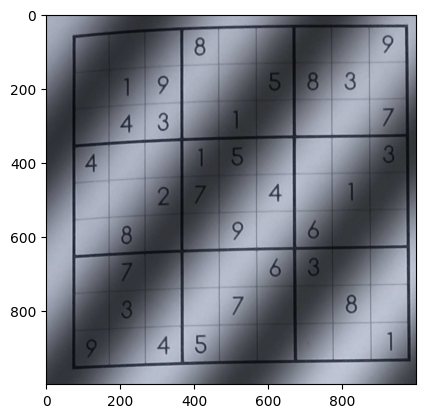

In [1178]:
plt.imshow(img_rgb);

# Convert to grayscale
We don't need any color information.

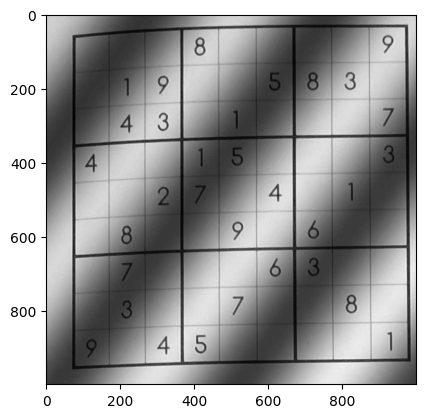

In [1179]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray");

## Histogram

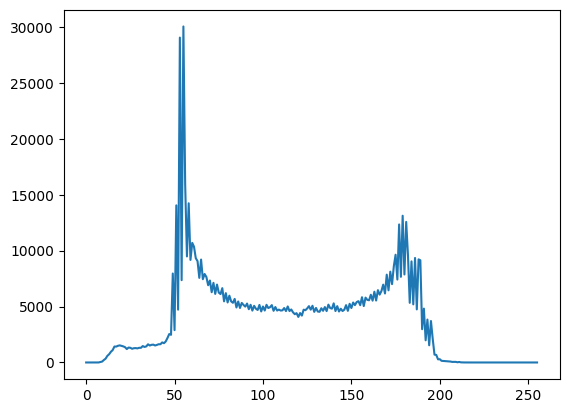

In [1180]:
hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])

plt.plot(hist)

## Median Filter

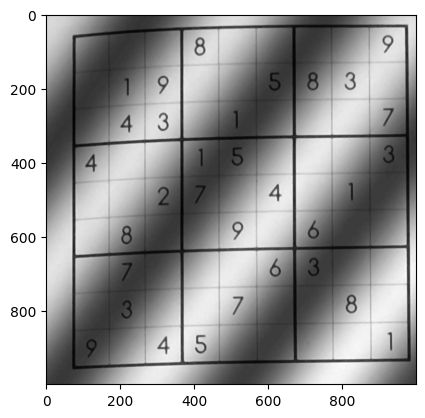

In [1181]:
median_filtered_image = cv2.medianBlur(img_gray, 5)
plt.imshow(median_filtered_image, cmap="gray");

## Histogram Equalization

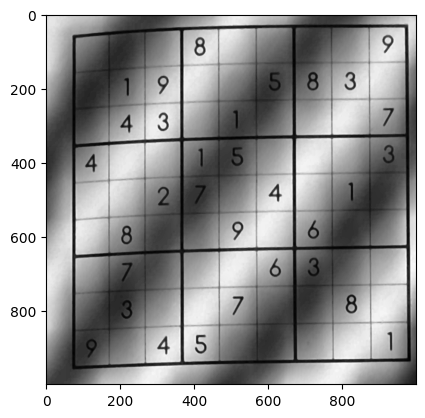

In [1182]:
# equalized_image = cv2.equalizeHist(median_filtered_image)
# plt.imshow(equalized_image, cmap="gray");
equalized_image = cv2.createCLAHE(clipLimit=2, tileGridSize=(10, 10))
equalized_image = equalized_image.apply(median_filtered_image)
plt.imshow(equalized_image, cmap="gray");

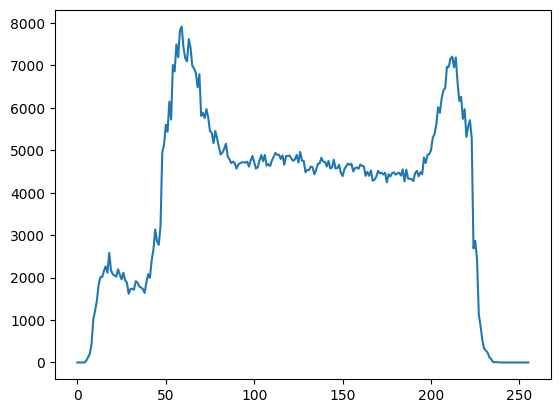

In [1183]:
hist = cv2.calcHist([equalized_image], [0], None, [256], [0, 256])
plt.plot(hist)

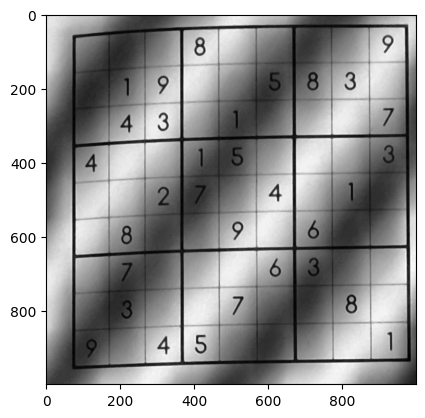

In [1184]:
roi = equalized_image[0:-1, 0:-1]

roi_contrast_stretched = cv2.normalize(roi, None, 0, 255, cv2.NORM_MINMAX)

equalized_image[0:-1, 0:-1] = roi_contrast_stretched

plt.imshow(equalized_image, cmap="gray");

peaks:  500


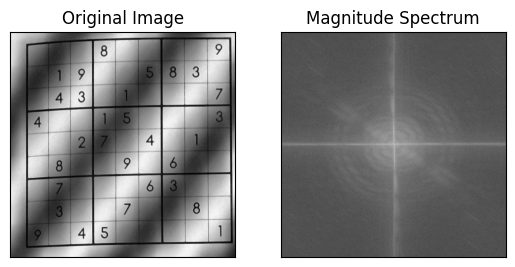

Sine waves detected in the image.


In [1200]:
f_transform = np.fft.fft2(equalized_image)
f_shift = np.fft.fftshift(f_transform)

magnitude_spectrum = np.log(np.abs(f_shift) + 1)

peaks = cv2.minMaxLoc(magnitude_spectrum)[3]


threshold = 0.8
sine_wave_detected = peaks[0] > threshold
print("peaks: ", peaks[0])

plt.subplot(121), plt.imshow(equalized_image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

if sine_wave_detected:
    print("Sine waves detected in the image.")
else:
    print("No sine waves detected in the image.")

In [1188]:
# equalized_image= img_filtered

## Check If Image is Inverted

In [1189]:
inverted_score = hist[0] + hist[-1]
print(inverted_score)
if (inverted_score> 500):
  equalized_image = cv2.bitwise_not(equalized_image)

[0.]


## Check if Image is too bright

In [1190]:
mask = cv2.inRange(equalized_image, 190, 220)

pixel_count = np.count_nonzero(mask)
print(pixel_count)

if pixel_count> 60500:
      pass

133992


## Sharpening

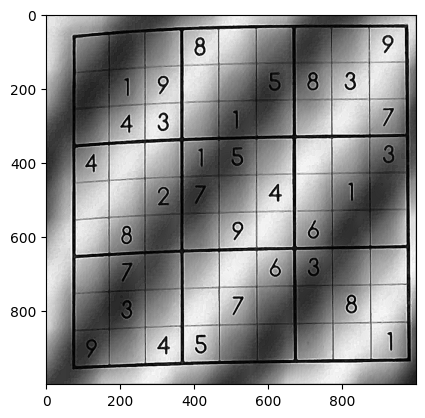

In [1191]:
kernel = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])
sharpened_image = cv2.filter2D(equalized_image, -1, kernel)

plt.imshow(sharpened_image, cmap="gray");

##Gaussian Blur

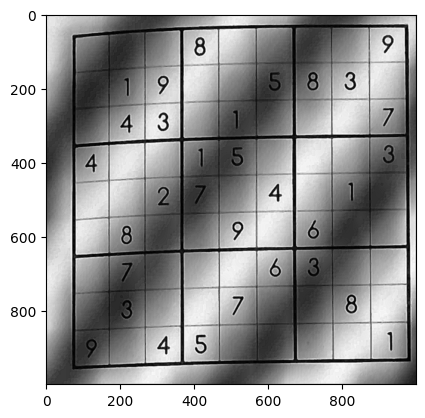

In [1192]:
img_Blur = cv2.GaussianBlur(sharpened_image,(3,3),0)
plt.imshow(img_Blur, cmap="gray");

# Thresholding step
We don't need the full scale of grayscale either, just binary. But, is ordinary thresholding enough? Or is "adaptive thresholding" better?

Do your research!

## Thresholding function to get C value based on histogram mode

In [1193]:
from scipy.stats import mode
def get_C_Value(hist):
   mode_pixel_value = np.argmax(hist)
   print("mode", mode_pixel_value)
   if mode_pixel_value >150 and mode_pixel_value <255 :
        c_value = 40
   else:
        c_value = 7

   return c_value


In [1194]:
print(img_Blur.shape)
print(img_Blur.dtype)

(1000, 1000)
uint8


mode 59


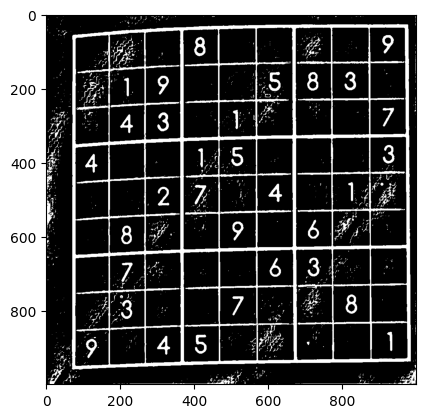

In [1198]:
img_gray_threshed = cv2.adaptiveThreshold(src=img_Blur.astype(np.uint8),
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=111,
    C=get_C_Value(hist)
)
plt.imshow(img_gray_threshed, cmap="gray");

## Closing:

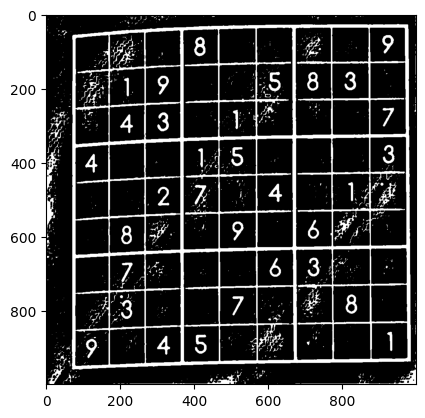

In [1199]:
kernel = np.ones((3, 3), np.uint8)

# Perform closing
dilated_image = cv2.morphologyEx(img_gray_threshed, cv2.MORPH_CLOSE, kernel)
plt.imshow(dilated_image, cmap="gray");